In [2]:
import numpy as np
import pandas as pd
# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

#from prophet import Prophet

In [3]:
df_products = pd.read_csv('../data/Top100_prediction_sin.csv')
df_products.head(5)

,Unnamed: 0,id,date,sales,item,sell_price,income
0,103,ACCESORIES_1_108_NYC_1,2011-01-29,4,ACCESORIES_1_108,16.1196,64.4784
1,591,HOME_&_GARDEN_1_027_NYC_1,2011-01-29,4,HOME_&_GARDEN_1_027,6.5500,26.2000
2,615,HOME_&_GARDEN_1_053_NYC_1,2011-01-29,0,HOME_&_GARDEN_1_053,18.7125,0.0000
3,700,HOME_&_GARDEN_1_140_NYC_1,2011-01-29,4,HOME_&_GARDEN_1_140,18.7500,75.0000
4,737,HOME_&_GARDEN_1_177_NYC_1,2011-01-29,0,HOME_&_GARDEN_1_177,9.9625,0.0000


In [4]:
df_products.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df_product = df_products[['date', 'income','item']]

In [6]:
df_product.head(2)

,date,income,item
0,2011-01-29,64.4784,ACCESORIES_1_108
1,2011-01-29,26.2000,HOME_&_GARDEN_1_027


In [7]:
df_SUPERMARKET_3_586 = df_product[df_product['item']=='SUPERMARKET_3_586']

In [8]:
ts_predict = df_SUPERMARKET_3_586.groupby(['date'])['income'].sum().reset_index() #ts=suma de todas las ventas de todas las tiendas agrupado por día

In [9]:
ts_predict.set_index('date', inplace=True)

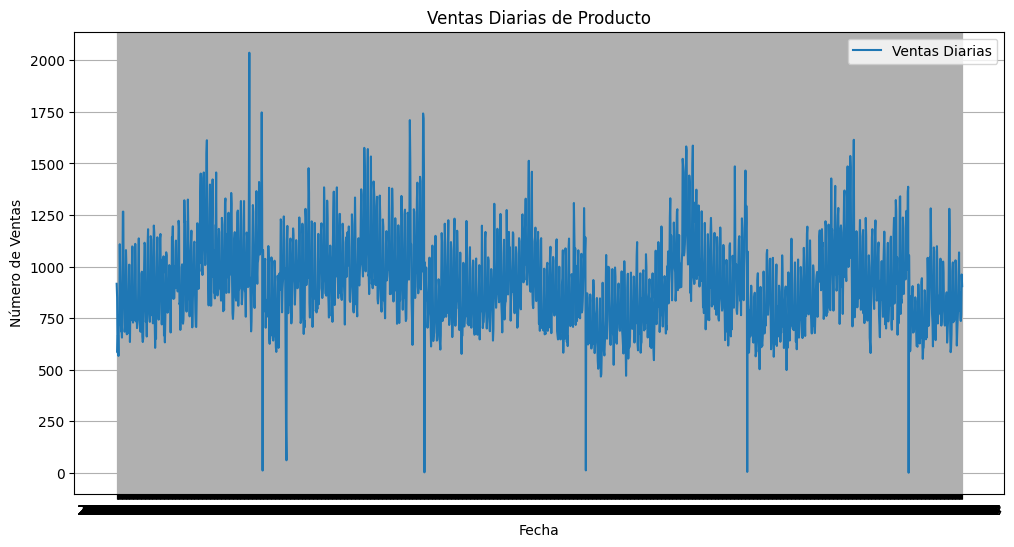

In [10]:
import matplotlib.pyplot as plt

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(ts_predict.index, ts_predict['income'], label='Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Número de Ventas')
plt.title('Ventas Diarias de Producto')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_predict['income'])
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')

Estadístico ADF: -3.8075214875178482
Valor p: 0.002831291037097126


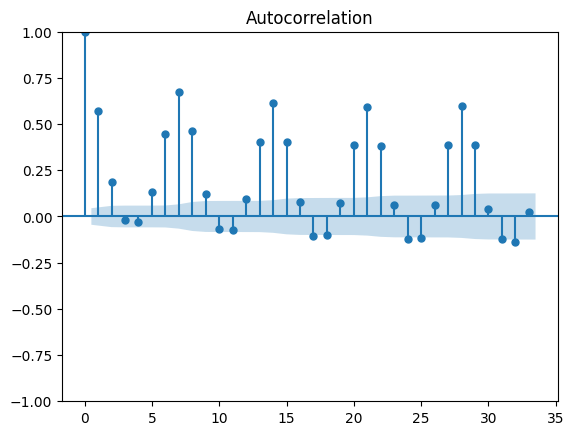

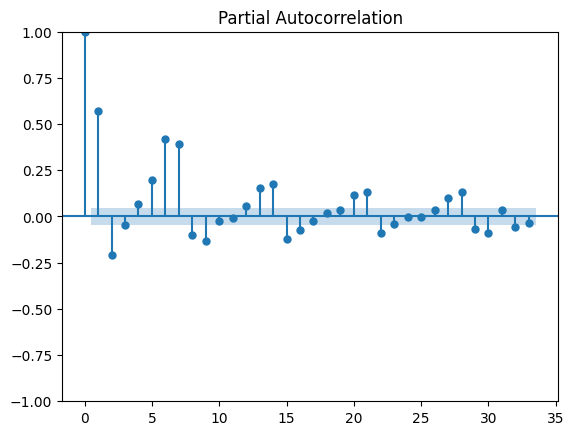

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_predict)
plt.show()

plot_pacf(ts_predict)
plt.show()

In [13]:
df_train = ts_predict[:-30]
df_test = ts_predict[-30:]

In [14]:
df_train

,income
date,
2011-01-29,916.416
2011-01-30,850.704
2011-01-31,582.528
2011-02-01,667.776
2011-02-02,566.544
...,...
2016-03-21,631.008
2016-03-22,675.360
2016-03-23,727.776


In [15]:
pdq = [
    (1, 0, 1), (1, 0, 2),
    (2, 0, 3), (2, 0, 4),
    (2, 0, 5), (2, 0, 1),
    (2, 0, 2), (2, 0, 3),
    (2, 0, 4),

    
    
    # Opciones con d = 1 (por si acaso)
    # (1, 1, 1), (1, 1, 2),
    # (2, 1, 1), (2, 1, 2)

    (1, 1, 1), (1, 1, 2),
    (2, 1, 3), (2, 1, 4),
    (2, 1, 5), (2, 1, 1),
    (2, 1, 2), (2, 1, 3),
    (2, 1, 4), (2, 1, 5)
]

# Probar también con algún P o Q diferente de 0 en la parte estacional
seasonal_pdq = (0, 1, 0, 7) # Actual
#     (1, 1, 0, 7),  # AR estacional
#     (0, 1, 1, 7),  # MA estacional
#     (1, 1, 1, 7)   # AR y MA estacional

In [17]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = df_train,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47444D+00    |proj g|=  1.07259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   4.739D-06   6.474D+00
  F =   6.4744385244001856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:24388.735482891097
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variable

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   4.677D-06   6.471D+00
  F =   6.4710266944385468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:24377.886531255568
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55052D+00    |proj g|=  5.04602D-01


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.63316D+00    |proj g|=  3.22987D-01

At iterate   10    f=  6.41767D+00    |proj g|=  3.67669D-01

At iterate   15    f=  6.41033D+00    |proj g|=  1.45891D-01

At iterate   20    f=  6.39575D+00    |proj g|=  5.24245D-02

At iterate   25    f=  6.39473D+00    |proj g|=  5.41664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     45      1     0     0   1.723D-04   6.395D+00
  F =   6.3947299253787202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:24094.55289897626


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46399D+00    |proj g|=  4.97676D-02

At iterate    5    f=  6.45550D+00    |proj g|=  6.72183D-03

At iterate   10    f=  6.45510D+00    |proj g|=  2.68255D-02

At iterate   15    f=  6.44888D+00    |proj g|=  2.53937D-01

At iterate   20    f=  6.41546D+00    |proj g|=  3.28635D-01

At iterate   25    f=  6.39605D+00    |proj g|=  3.55309D-01

At iterate   30    f=  6.39346D+00    |proj g|=  1.79653D-01

At iterate   35    f=  6.39141D+00    |proj g|=  1.93937D-01

At iterate   40    f=  6.38987D+00    |proj g|=  8.60681D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     87      1     0     0   8.607D-04   6.390D+00
  F =   6.3898669052293284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:24078.23876509365
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45662D+00    |proj g|=  6.66659D-02


 This problem is unconstrained.



At iterate    5    f=  6.42606D+00    |proj g|=  1.64009D-01

At iterate   10    f=  6.37306D+00    |proj g|=  2.31873D-01

At iterate   15    f=  6.36024D+00    |proj g|=  2.62717D-01

At iterate   20    f=  6.35887D+00    |proj g|=  8.05078D-02

At iterate   25    f=  6.35802D+00    |proj g|=  2.85423D-03

At iterate   30    f=  6.35799D+00    |proj g|=  8.42853D-03

At iterate   35    f=  6.35798D+00    |proj g|=  2.66697D-03

At iterate   40    f=  6.35790D+00    |proj g|=  3.22367D-02

At iterate   45    f=  6.35535D+00    |proj g|=  8.44139D-02

At iterate   50    f=  6.34710D+00    |proj g|=  9.01722D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 5)x(0, 1, 0, 7)12 - AIC:23919.163429357133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47441D+00    |proj g|=  7.10373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      1     0     0   5.950D-06   6.474D+00
  F =   6.4744105254091266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1)x(0, 1, 0, 7)12 - AIC:24390.63003869077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47896D+00    |proj g|=  3.04680D-01

At iterate    5    f=  6.59449D+00    |proj g|=  3.30198D-01


 This problem is unconstrained.



At iterate   10    f=  6.47017D+00    |proj g|=  8.29323D-03

At iterate   15    f=  6.47001D+00    |proj g|=  6.94382D-03

At iterate   20    f=  6.46997D+00    |proj g|=  2.43164D-03

At iterate   25    f=  6.46964D+00    |proj g|=  3.25267D-02

At iterate   30    f=  6.46374D+00    |proj g|=  5.13802D-02

At iterate   35    f=  6.46248D+00    |proj g|=  2.09068D-03

At iterate   40    f=  6.46246D+00    |proj g|=  6.36374D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     67      1     0     0   6.364D-05   6.462D+00
  F =   6.4624615967628136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 1, 0, 7)12 - AIC:24347.630373408756
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55052D+00    |proj g|=  5.04602D-01

At iterate    5    f=  6.63316D+00    |proj g|=  3.22987D-01

At iterate   10    f=  6.41767D+00    |proj g|=  3.67669D-01

At iterate   1

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46399D+00    |proj g|=  4.97676D-02

At iterate    5    f=  6.45550D+00    |proj g|=  6.72183D-03

At iterate   10    f=  6.45510D+00    |proj g|=  2.68255D-02

At iterate   15    f=  6.44888D+00    |proj g|=  2.53937D-01

At iterate   20    f=  6.41546D+00    |proj g|=  3.28635D-01

At iterate   25    f=  6.39605D+00    |proj g|=  3.55309D-01

At iterate   30    f=  6.39346D+00    |proj g|=  1.79653D-01

At iterate   35    f=  6.39141D+00    |proj g|=  1.93937D-01

At iterate   40    f=  6.38987D+00    |proj g|=  8.60681D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     87      1     0     0   8.607D-04   6.390D+00
  F =   6.3898669052293284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:24078.23876509365
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53629D+00    |proj g|=  1.36035D-01

At iterate    5    f=  6.48140D+00    |proj g|=  2.46951D-01

At iterate   10    f=  6.48128D+00    |proj g|=  1.34167D-03

At iterate   15

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.47741D+00    |proj g|=  3.76614D-02

At iterate   10    f=  6.47488D+00    |proj g|=  6.44725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     22      1     0     0   7.780D-04   6.475D+00
  F =   6.4747740443283410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:24391.999050940532


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54778D+00    |proj g|=  1.82330D+02

At iterate    5    f=  6.56672D+00    |proj g|=  2.11835D-01

At iterate   10    f=  6.51645D+00    |proj g|=  1.85171D-01
  ys=-3.227E-02  -gs= 1.008E-02 BFGS update SKIPPED

At iterate   15    f=  6.48131D+00    |proj g|=  9.39003D-02

At iterate   20    f=  6.47858D+00    |proj g|=  1.37385D-01

At iterate   25    f=  6.46845D+00    |proj g|=  8.63153D-02

At iterate   30    f=  6.46711D+00    |proj g|=  1.94447D-01
  ys=-1.289E-04  -gs= 3.891E-04 BFGS update SKIPPED

At iterate   35    f=  6.46619D+00    |proj g|=  2.36157D-02

At iterate   40    f=  6.46618D+00    |proj g|=  2.90400D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     89      1     2     0   7.763D-04   6.466D+00
  F =   6.4661844423588288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 3)x(0, 1, 0, 7)12 - AIC:24363.65060992335
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51757D+00    |proj g|=  9.96011D-02


 This problem is unconstrained.



At iterate    5    f=  6.46910D+00    |proj g|=  1.36314D-02

At iterate   10    f=  6.46370D+00    |proj g|=  1.98063D-01

At iterate   15    f=  6.42350D+00    |proj g|=  2.38852D-01

At iterate   20    f=  6.41176D+00    |proj g|=  5.89791D-02

At iterate   25    f=  6.41115D+00    |proj g|=  7.51573D-03

At iterate   30    f=  6.41102D+00    |proj g|=  5.54283D-03

At iterate   35    f=  6.41101D+00    |proj g|=  8.41402D-03

At iterate   40    f=  6.41088D+00    |proj g|=  6.19592D-02

At iterate   45    f=  6.41013D+00    |proj g|=  1.56230D-01


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.39794D+00    |proj g|=  4.52552D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   4.526D-01   6.398D+00
  F =   6.3979359537031586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:24108.626801646096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51137D+00    |proj g|=  9.36478D-02


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-8.160E-04  -gs= 3.734E-02 BFGS update SKIPPED

At iterate    5    f=  6.46677D+00    |proj g|=  1.21652D-01

At iterate   10    f=  6.46474D+00    |proj g|=  1.35549D-02

At iterate   15    f=  6.46395D+00    |proj g|=  9.96489D-02

At iterate   20    f=  6.44327D+00    |proj g|=  2.50586D-01

At iterate   25    f=  6.42005D+00    |proj g|=  1.42616D-01

At iterate   30    f=  6.41790D+00    |proj g|=  2.00467D-02

At iterate   35    f=  6.41769D+00    |proj g|=  4.20031D-03

At iterate   40    f=  6.41761D+00    |proj g|=  4.78095D-02

At iterate   45    f=  6.41661D+00    |proj g|=  8.05224D-02


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  6.41614D+00    |proj g|=  1.41027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      2     1     0   1.410D-02   6.416D+00
  F =   6.4161351649871028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:24179.16503134143


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52257D+00    |proj g|=  2.48910D-01

At iterate    5    f=  6.48083D+00    |proj g|=  1.42591D-01

At iterate   10    f=  6.47906D+00    |proj g|=  4.01444D-03

At iterate   15    f=  6.47899D+00    |proj g|=  7.58295D-03

At iterate   20    f=  6.47663D+00    |proj g|=  8.82594D-02

At iterate   25    f=  6.47314D+00    |proj g|=  1.59512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     37      1     0     0   

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.47309D+00    |proj g|=  2.30929D+00

At iterate   10    f=  6.47218D+00    |proj g|=  5.24108D-02

At iterate   15    f=  6.47208D+00    |proj g|=  2.23857D+00

At iterate   20    f=  6.47107D+00    |proj g|=  2.48574D+00

At iterate   25    f=  6.47106D+00    |proj g|=  2.22536D-02

At iterate   30    f=  6.47105D+00    |proj g|=  4.06314D-01

At iterate   35    f=  6.47081D+00    |proj g|=  3.92318D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so infer


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     91      2     0     0   7.573D-01   6.471D+00
  F =   6.4705699647233370     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:24378.166487148086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54778D+00    |proj g|=  1.82330D+02

At iterate    5    f=  6.56672D+00    |proj g|=  2.11835D-01

At iterate   10    f=  6.51645D+00    |proj g|=  1.85171D-01
  ys=-3.227E-02


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  6.46910D+00    |proj g|=  1.36314D-02

At iterate   10    f=  6.46370D+00    |proj g|=  1.98063D-01

At iterate   15    f=  6.42350D+00    |proj g|=  2.38852D-01

At iterate   20    f=  6.41176D+00    |proj g|=  5.89791D-02

At iterate   25    f=  6.41115D+00    |proj g|=  7.51573D-03

At iterate   30    f=  6.41102D+00    |proj g|=  5.54283D-03

At iterate   35    f=  6.41101D+00    |proj g|=  8.41402D-03

At iterate   40    f=  6.41088D+00    |proj g|=  6.19592D-02

At iterate   45    f=  6.41013D+00    |proj g|=  1.56230D-01


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.39794D+00    |proj g|=  4.52552D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   4.526D-01   6.398D+00
  F =   6.3979359537031586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:24108.626801646096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51137D+00    |proj g|=  9.36478D-02


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-8.160E-04  -gs= 3.734E-02 BFGS update SKIPPED

At iterate    5    f=  6.46677D+00    |proj g|=  1.21652D-01

At iterate   10    f=  6.46474D+00    |proj g|=  1.35549D-02

At iterate   15    f=  6.46395D+00    |proj g|=  9.96489D-02

At iterate   20    f=  6.44327D+00    |proj g|=  2.50586D-01

At iterate   25    f=  6.42005D+00    |proj g|=  1.42616D-01

At iterate   30    f=  6.41790D+00    |proj g|=  2.00467D-02

At iterate   35    f=  6.41769D+00    |proj g|=  4.20031D-03

At iterate   40    f=  6.41761D+00    |proj g|=  4.78095D-02

At iterate   45    f=  6.41661D+00    |proj g|=  8.05224D-02


/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.41614D+00    |proj g|=  1.41027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      2     1     0   1.410D-02   6.416D+00
  F =   6.4161351649871028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:24179.16503134143


In [18]:
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

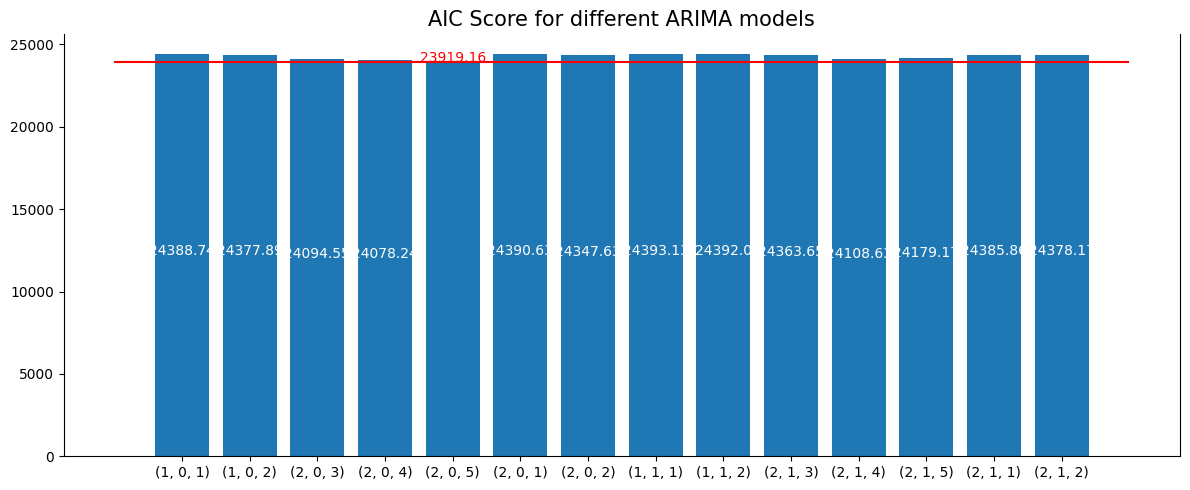

In [19]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [20]:
RESULTS_DICT

{(1, 0, 1): 24388.74,
 (1, 0, 2): 24377.89,
 (2, 0, 3): 24094.55,
 (2, 0, 4): 24078.24,
 (2, 0, 5): 23919.16,
 (2, 0, 1): 24390.63,
 (2, 0, 2): 24347.63,
 (1, 1, 1): 24393.13,
 (1, 1, 2): 24392.0,
 (2, 1, 3): 24363.65,
 (2, 1, 4): 24108.63,
 (2, 1, 5): 24179.17,
 (2, 1, 1): 24385.86,
 (2, 1, 2): 24378.17}

In [21]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(2, 0, 5)
Con un score AIC de 23919.16.
En la posición 4



In [16]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df_train,
    order = (2,0,4),
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46399D+00    |proj g|=  4.97676D-02

At iterate    5    f=  6.45550D+00    |proj g|=  6.72183D-03

At iterate   10    f=  6.45510D+00    |proj g|=  2.68255D-02

At iterate   15    f=  6.44888D+00    |proj g|=  2.53937D-01

At iterate   20    f=  6.41546D+00    |proj g|=  3.28635D-01

At iterate   25    f=  6.39605D+00    |proj g|=  3.55309D-01

At iterate   30    f=  6.39346D+00    |proj g|=  1.79653D-01

At iterate   35    f=  6.39141D+00    |proj g|=  1.93937D-01

At iterate   40    f=  6.38987D+00    |proj g|=  8.60681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [23]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0261      0.025     41.604      0.000       0.978       1.074
ar.L2         -0.6513      0.019    -34.592      0.000      -0.688      -0.614
ma.L1         -0.8052      0.026    -30.562      0.000      -0.857      -0.754
ma.L2          0.6184      0.026     23.591      0.000       0.567       0.670
ma.L3          0.2248      0.027      8.390      0.000       0.172       0.277
ma.L4          0.1709      0.028      6.036      0.000       0.115       0.226
sigma2      2.583e+04    402.574     64.160      0.000     2.5e+04    2.66e+04


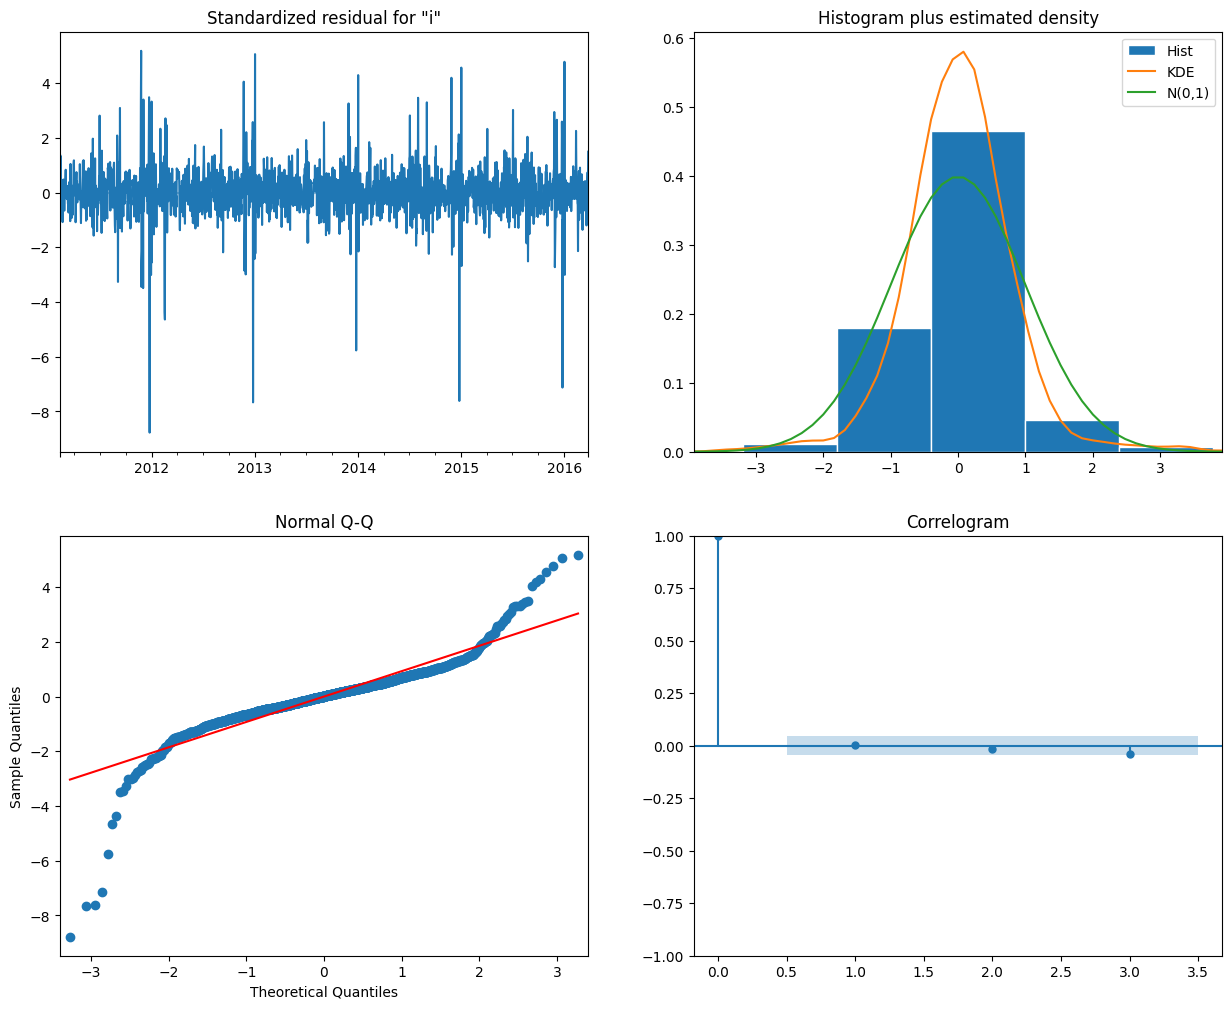

In [17]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

In [18]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(df_test))
y_pred_test = pred_uc.predicted_mean

# 1. Calcular el MSE
mse = mean_squared_error(df_test['income'], y_pred_test)
print(mse)
# 2. Calcular el RMSPE
rmspe = np.sqrt(np.mean(((df_test - y_pred_test) / df_test) ** 2)) * 100
print(f'El error RMSPE es: {rmspe:.2f}%')
rmse = np.sqrt(mean_squared_error(df_test['income'], y_pred_test))
print(f'RMSE: {rmse}')

11198.84357076679
El error RMSPE es: nan%
RMSE: 105.82458868697195


In [25]:
resultado = {'predicion': y_pred_test.values, 'test':df_test['income']}

In [26]:
pd.DataFrame(resultado)

,predicion,test
date,,
2016-03-26,993.746783,1280.160
2016-03-27,1023.172091,1167.264
2016-03-28,744.836123,683.424
2016-03-29,736.647866,584.640
2016-03-30,716.525417,604.800
2016-03-31,736.793775,669.312
2016-04-01,970.586046,816.480
2016-04-02,980.599921,977.760
2016-04-03,1039.302671,1020.096


In [21]:
ts_predict.reset_index(inplace=True)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.set_index('date', inplace=True)
#y_pred_test.set_index('date', inplace=True)

Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

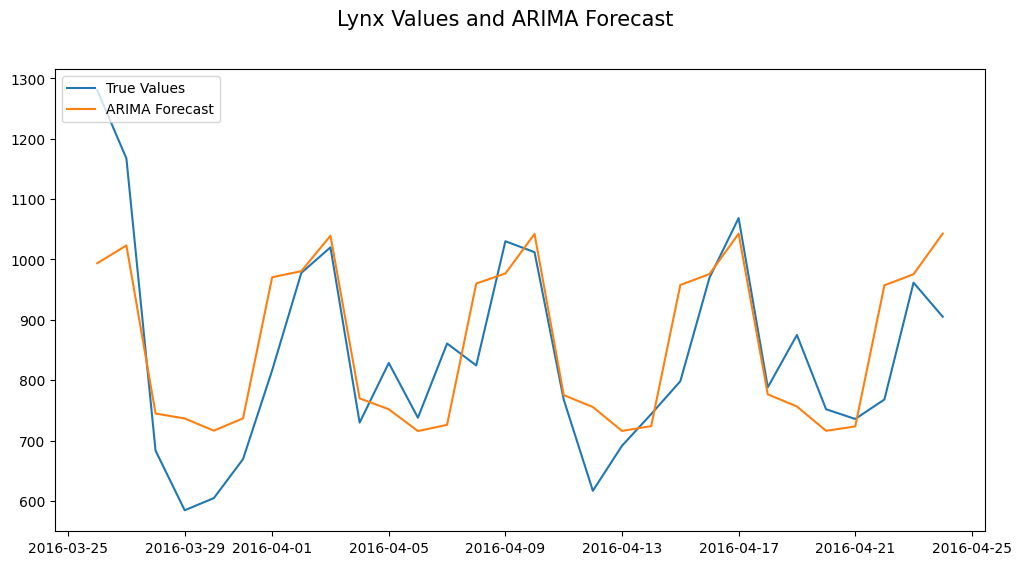

In [22]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_predict[-30:], label = "True Values")
ax.plot(y_pred_test, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_test['income'], y_pred_test))
print(f'RMSE: {rmse}')

RMSE: 105.82458868697195
